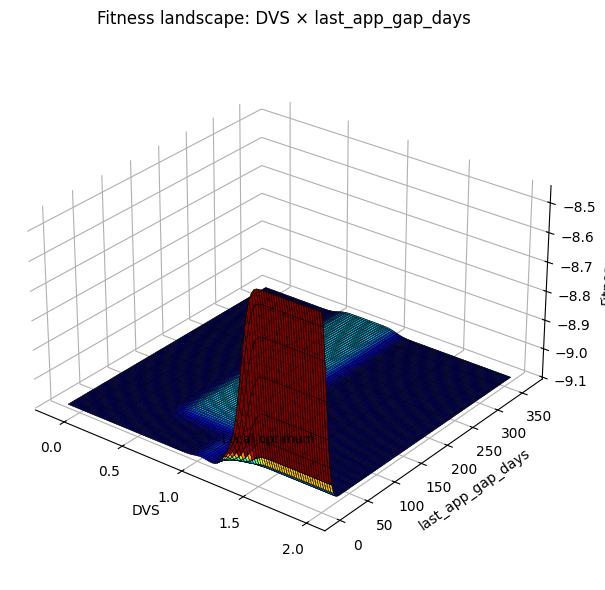

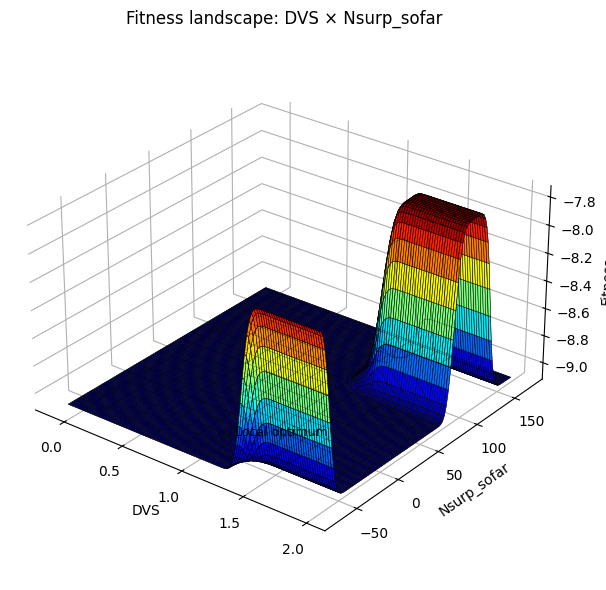

In [1]:
# === Fitness landscapes from XCSR population dump (styled like the example) ===
# - Input schema expected: action,pred,fit,eps,exp,num,as_size, lower[i],upper[i],mask[i] for i=0..12
# - FEATURE_ORDER must match the order used when training the agent!

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

# ---- 0) CONFIG --------------------------------------------------------------
CSV = r"C:\Users\Simon\PycharmProjects\Masterthesis7\data\wofost81\output\population_min.csv"  # <- set your path
FEATURE_ORDER = [
    "DVS","LAI","RFTRA","WSO","Nsurp_sofar","last_dose_kg_ha","last_app_gap_days",
    "cum_N_applied_kg_ha","IRRAD_7","TMEAN_7","RAIN_7","Ndep_sum","SM_mean",
]
N_GRID = 110     # grid resolution (increase for smoother surface)
MIN_EXP = 1      # ignore very immature rules (< MIN_EXP)
SAVE_PNGS = False

# ---- 1) LOAD & CHECK --------------------------------------------------------
df = pd.read_csv(CSV)
K = len(FEATURE_ORDER)

need = ["action","pred","fit","eps","exp","num"] \
     + [f"lower[{i}]" for i in range(K)] \
     + [f"upper[{i}]" for i in range(K)] \
     + [f"mask[{i}]"  for i in range(K)]
missing = [c for c in need if c not in df.columns]
assert not missing, f"CSV is missing columns: {missing[:10]} ..."

# Pre-extract arrays (vectorized)
lower = np.stack([df[f"lower[{i}]"].to_numpy(float) for i in range(K)], axis=1)
upper = np.stack([df[f"upper[{i}]"].to_numpy(float) for i in range(K)], axis=1)
mask  = np.stack([df[f"mask[{i}]"].to_numpy(int)   for i in range(K)], axis=1).astype(bool)   # True = don't-care
cares = ~mask

pred = df["pred"].to_numpy(float)
fit  = df["fit"].to_numpy(float)
num  = df["num"].to_numpy(float)
eps  = df["eps"].to_numpy(float)
exp  = df["exp"].to_numpy(float)
act  = df["action"].to_numpy()

# ---- 2) HELPERS -------------------------------------------------------------
def typical_values():
    """Median of midpoints for rules that 'care' per feature (robust to outliers)."""
    tv = np.zeros(K, dtype=float)
    for i in range(K):
        idx = np.where(cares[:, i])[0]
        mids = 0.5*(lower[idx, i] + upper[idx, i]) if idx.size else 0.5*(lower[:, i] + upper[:, i])
        tv[i] = float(np.nanmedian(mids))
    return tv

def robust_axis_domain(i, qlo=0.02, qhi=0.98):
    """Quantile-based domain for plotting (avoids crazy outliers)."""
    idx = np.where(cares[:, i])[0]
    lo_vals = lower[idx, i] if idx.size else lower[:, i]
    hi_vals = upper[idx, i] if idx.size else upper[:, i]
    lo_q = float(np.nanquantile(lo_vals, qlo))
    hi_q = float(np.nanquantile(hi_vals, qhi))
    if not np.isfinite(hi_q) or hi_q <= lo_q or hi_q > 1e6:
        hi_q = float(np.nanquantile(lo_vals, qhi))
    return lo_q, hi_q

def build_landscape(x_feat, y_feat, n_grid=N_GRID, min_exp=MIN_EXP):
    """Return X, Y, Z where Z(i,j) = max_a P_a(s) at state s with x/y set to grid and others fixed."""
    tv = typical_values()
    xi = FEATURE_ORDER.index(x_feat)
    yi = FEATURE_ORDER.index(y_feat)

    x_lo, x_hi = robust_axis_domain(xi)
    y_lo, y_hi = robust_axis_domain(yi)
    X = np.linspace(x_lo, x_hi, n_grid)
    Y = np.linspace(y_lo, y_hi, n_grid)
    Z = np.full((n_grid, n_grid), np.nan, dtype=float)

    # speed trick: filter once per X then refine on Y
    for ix, xv in enumerate(X):
        s = tv.copy(); s[xi] = float(xv)
        s_row = s.reshape(1, K)
        ge_lo_x = (lower <= s_row)
        le_hi_x = (s_row <= upper)
        match_x = np.all(np.logical_or(~cares, (ge_lo_x & le_hi_x)), axis=1) & (exp >= min_exp)
        idx_x = np.where(match_x)[0]
        if idx_x.size == 0:
            continue

        lower_y = lower[idx_x, yi]; upper_y = upper[idx_x, yi]; cares_y = cares[idx_x, yi]
        w_base  = fit[idx_x] * num[idx_x] / (1.0 + np.maximum(eps[idx_x], 0.0))
        a = act[idx_x]; p = pred[idx_x]

        for iy, yv in enumerate(Y):
            within_y = np.logical_or(~cares_y, ((lower_y <= yv) & (yv <= upper_y)))
            sel = np.where(within_y)[0]
            if sel.size == 0:
                continue
            w = w_base[sel]; aa = a[sel]; pp = p[sel]
            # weighted prediction per action
            Pa = {}
            for ua in np.unique(aa):
                ssel = (aa == ua)
                wsum = float(np.sum(w[ssel]))
                if wsum > 0:
                    Pa[ua] = float(np.dot(w[ssel], pp[ssel]) / wsum)
            if Pa:
                Z[iy, ix] = max(Pa.values())
    return X, Y, Z

def inpaint_nans(Z, iters=80):
    """Fill NaN holes by averaging available neighbors (simple inpainting)."""
    Z = Z.copy(); h, w = Z.shape
    for _ in range(iters):
        nan_mask = np.isnan(Z)
        if not nan_mask.any(): break
        Z_new = Z.copy(); changed = 0
        for i in range(h):
            for j in range(w):
                if np.isnan(Z[i, j]):
                    vals = []
                    for di in (-1,0,1):
                        for dj in (-1,0,1):
                            if di==0 and dj==0: continue
                            ii, jj = i+di, j+dj
                            if 0<=ii<h and 0<=jj<w and not np.isnan(Z[ii, jj]):
                                vals.append(Z[ii, jj])
                    if vals:
                        Z_new[i, j] = float(np.mean(vals)); changed += 1
        Z = Z_new
        if changed == 0: break
    return Z

def box_smooth(Z, iters=8):
    """Mild 3×3 smoothing for a cleaner surface."""
    Z = Z.copy(); h, w = Z.shape
    for _ in range(iters):
        Z_new = Z.copy()
        for i in range(h):
            for j in range(w):
                vals = []
                for di in (-1,0,1):
                    for dj in (-1,0,1):
                        ii, jj = i+di, j+dj
                        if 0<=ii<h and 0<=jj<w and not np.isnan(Z[ii, jj]):
                            vals.append(Z[ii, jj])
                if vals:
                    Z_new[i, j] = float(np.mean(vals))
        Z = Z_new
    return Z

def find_local_extrema(Z, kind="max", n=2):
    """Return top-n local extrema positions."""
    h, w = Z.shape; cands = []
    for i in range(1, h-1):
        for j in range(1, w-1):
            if np.isnan(Z[i, j]): continue
            hood = Z[i-1:i+2, j-1:j+2]
            if kind == "max":
                if np.nanmax(hood) == Z[i, j] and np.nansum(hood == Z[i, j]) == 1:
                    cands.append((Z[i, j], i, j))
            else:
                if np.nanmin(hood) == Z[i, j] and np.nansum(hood == Z[i, j]) == 1:
                    cands.append((Z[i, j], i, j))
    cands.sort(reverse=(kind=="max"), key=lambda x: x[0])
    return cands[:n]

def plot_styled_surface(X, Y, Z, xlab, ylab, title=None, save_path=None):
    """3D surface styled like the reference image: rainbow, mesh gridlines, clean background."""
    XX, YY = np.meshgrid(X, Y)
    Z = inpaint_nans(Z, iters=80)
    Z = box_smooth(Z, iters=10)

    # color normalization so mid values ≈ green
    vmin = float(np.nanpercentile(Z, 2))
    vmax = float(np.nanpercentile(Z, 98))
    norm = colors.Normalize(vmin=vmin, vmax=vmax)

    fig = plt.figure(figsize=(10,6), facecolor="white")
    ax = fig.add_subplot(111, projection='3d')
    ax.set_facecolor("white")
    for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
        axis.pane.set_edgecolor('w')
        axis.pane.fill = False

    ax.plot_surface(XX, YY, Z, cmap="jet", norm=norm,
                    edgecolor="k", linewidth=0.35, rstride=1, cstride=1,
                    antialiased=True, alpha=1.0, shade=True)
    ax.plot_wireframe(XX, YY, Z, rstride=6, cstride=6, color="k", linewidth=0.30, alpha=0.6)

    ax.set_xlabel(xlab); ax.set_ylabel(ylab); ax.set_zlabel("Fitness")
    if title: ax.set_title(title)
    ax.view_init(elev=28, azim=-52)
    ax.set_box_aspect((1, 1, 0.6))

    # annotate a couple of local optima/minima
    for val, i, j in find_local_extrema(Z, "max", n=2):
        ax.text(X[j], Y[i], Z[i, j], "Local optimum", fontsize=9)
    for val, i, j in find_local_extrema(Z, "min", n=1):
        ax.text(X[j], Y[i], Z[i, j], "Local minimum", fontsize=9)

    plt.tight_layout()
    if SAVE_PNGS and save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

# ---- 3) BUILD & PLOT THE TWO SURFACES --------------------------------------
for xf, yf in [("DVS","last_app_gap_days"), ("DVS","Nsurp_sofar")]:
    X, Y, Z = build_landscape(xf, yf)
    plot_styled_surface(X, Y, Z, xlab=xf, ylab=yf, title=f"Fitness landscape: {xf} × {yf}",
                        save_path=f"{xf}_vs_{yf}_styled.png")


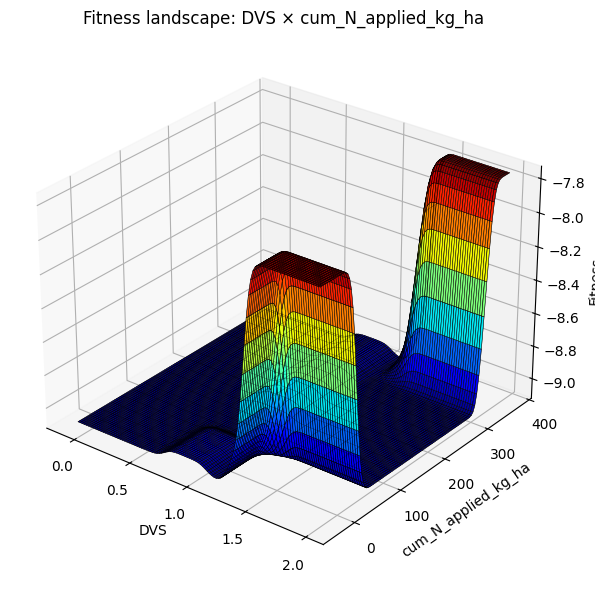

In [1]:
# === Flexible fitness landscape (choose axes, z, ranges, and alternate CSV columns) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib import colors

# --- CONFIG ------------------------------------------------------------------
CSV = r"C:\Users\Simon\PycharmProjects\Masterthesis7\data\wofost81\output\population_min.csv"

# The order your agent used for lower[i]/upper[i]/mask[i]
FEATURE_ORDER = [
    "DVS","LAI","RFTRA","WSO","Nsurp_sofar","last_dose_kg_ha","last_app_gap_days",
    "cum_N_applied_kg_ha","IRRAD_7","TMEAN_7","RAIN_7","Ndep_sum","SM_mean",
]
K = len(FEATURE_ORDER)

# Pick what to plot
X_FEAT = "DVS"
Y_FEAT = "cum_N_applied_kg_ha"

# Z surface: 'max' (max_a P_a(s)) or 'fixed_action'
Z_MODE = "max"           # "max" or "fixed_action"
Z_ACTION = 10            # only used if Z_MODE == "fixed_action" (dose index)

N_GRID = 110             # grid resolution
MIN_EXP = 1              # ignore very immature rules
SAVE_PNG = False
OUT = "landscape.png"

# (Optional) manually override axis ranges
AXIS_RANGE_OVERRIDE = {
    # "DVS": (0.0, 2.0),
    # "Nsurp_sofar": (-50, 150),
}

# (Optional) convert display units <-> model units (used at grid creation time)
# Example: if WSO in model is normalized 0..1 but you want kg/ha on the axis:
# AXIS_TO_MODEL["WSO"] = lambda raw: raw/15000.0
# AXIS_FROM_MODEL["WSO"] = lambda m: m*15000.0
AXIS_TO_MODEL  = {}
AXIS_FROM_MODEL = {}

# (Optional) tell the code to use *named* CSV columns for a feature’s intervals,
# instead of lower[i]/upper[i]/mask[i]. ONLY put entries you actually have.
# Example if your CSV also has "DVS_lo_raw","DVS_hi_raw","DVS_mask":
# INTERVAL_OVERRIDE = {"DVS": ("DVS_lo_raw","DVS_hi_raw","DVS_mask")}
INTERVAL_OVERRIDE = {}

# --- LOAD --------------------------------------------------------------------
df = pd.read_csv(CSV)

def col_or_none(name):
    return name if name in df.columns else None

# Build default interval matrices from indexed columns
lower = np.stack([df[f"lower[{i}]"].to_numpy(float) for i in range(K)], axis=1)
upper = np.stack([df[f"upper[{i}]"].to_numpy(float) for i in range(K)], axis=1)
mask  = np.stack([df[f"mask[{i}]"].to_numpy(int)   for i in range(K)], axis=1).astype(bool)  # True = don't care

# If you have alternate columns for a particular feature, swap them in here
for feat, cols in INTERVAL_OVERRIDE.items():
    i = FEATURE_ORDER.index(feat)
    lo_col, hi_col, mask_col = cols
    assert lo_col in df.columns and hi_col in df.columns and mask_col in df.columns, \
        f"Missing override columns for {feat}: {cols}"
    lower[:, i] = df[lo_col].to_numpy(float)
    upper[:, i] = df[hi_col].to_numpy(float)
    mask[:,  i] = df[mask_col].to_numpy(int).astype(bool)

cares = ~mask

pred = df["pred"].to_numpy(float)
fit  = df["fit"].to_numpy(float)
num  = df["num"].to_numpy(float) if "num" in df.columns else np.ones(len(df))
eps  = df["eps"].to_numpy(float) if "eps" in df.columns else np.zeros(len(df))
exp  = df["exp"].to_numpy(float) if "exp" in df.columns else np.zeros(len(df))
act  = df["action"].to_numpy()

# --- HELPERS -----------------------------------------------------------------
def typical_values():
    tv = np.zeros(K, dtype=float)
    for i in range(K):
        idx = np.where(cares[:, i])[0]
        mids = 0.5*(lower[idx, i] + upper[idx, i]) if idx.size else 0.5*(lower[:, i] + upper[:, i])
        tv[i] = float(np.nanmedian(mids))
    return tv

def robust_axis_domain(i, qlo=0.02, qhi=0.98):
    # If user supplied a manual override, use it (in DISPLAY units)
    feat = FEATURE_ORDER[i]
    if feat in AXIS_RANGE_OVERRIDE:
        lo_disp, hi_disp = AXIS_RANGE_OVERRIDE[feat]
        # convert to model units for matching
        to_model = AXIS_TO_MODEL.get(feat, lambda v: v)
        return to_model(lo_disp), to_model(hi_disp)

    # Otherwise infer from intervals (model units)
    idx = np.where(cares[:, i])[0]
    lo_vals = lower[idx, i] if idx.size else lower[:, i]
    hi_vals = upper[idx, i] if idx.size else upper[:, i]
    lo_q = float(np.nanquantile(lo_vals, qlo))
    hi_q = float(np.nanquantile(hi_vals, qhi))
    if not np.isfinite(hi_q) or hi_q <= lo_q or hi_q > 1e6:
        hi_q = float(np.nanquantile(lo_vals, qhi))
    return lo_q, hi_q

def system_prediction_from_subset(idx_rows):
    w = fit[idx_rows] * num[idx_rows]
    w = w / (1.0 + np.maximum(eps[idx_rows], 0.0))
    a = act[idx_rows]; p = pred[idx_rows]
    Pa = {}
    for ua in np.unique(a):
        sel = (a == ua)
        wsum = float(np.sum(w[sel]))
        if wsum > 0:
            Pa[ua] = float(np.dot(w[sel], p[sel]) / wsum)
    return Pa

def build_landscape(x_feat, y_feat, n_grid=N_GRID, min_exp=MIN_EXP):
    tv = typical_values()
    xi = FEATURE_ORDER.index(x_feat)
    yi = FEATURE_ORDER.index(y_feat)

    # grid in MODEL units (because matching needs model units)
    x_lo_m, x_hi_m = robust_axis_domain(xi)
    y_lo_m, y_hi_m = robust_axis_domain(yi)
    X_model = np.linspace(x_lo_m, x_hi_m, n_grid)
    Y_model = np.linspace(y_lo_m, y_hi_m, n_grid)

    # also compute DISPLAY values for nice axis labels
    from_model_x = AXIS_FROM_MODEL.get(x_feat, lambda v: v)
    from_model_y = AXIS_FROM_MODEL.get(y_feat, lambda v: v)
    X_disp = from_model_x(X_model)
    Y_disp = from_model_y(Y_model)

    Z = np.full((n_grid, n_grid), np.nan, dtype=float)

    # Pre-filter per X to speed up
    for ix, xv in enumerate(X_model):
        s = tv.copy(); s[xi] = float(xv)
        s_row = s.reshape(1, K)
        ge_lo_x = lower <= s_row
        le_hi_x = s_row <= upper
        match_x = np.all(np.logical_or(~cares, (ge_lo_x & le_hi_x)), axis=1) & (exp >= min_exp)
        idx_x = np.where(match_x)[0]
        if idx_x.size == 0:
            continue

        # Precompute arrays for Y test on that subset
        lower_y = lower[idx_x, yi]; upper_y = upper[idx_x, yi]; cares_y = cares[idx_x, yi]
        a = act[idx_x]; p = pred[idx_x]
        w_base = fit[idx_x] * num[idx_x] / (1.0 + np.maximum(eps[idx_x], 0.0))

        for iy, yv in enumerate(Y_model):
            within_y = np.logical_or(~cares_y, ((lower_y <= yv) & (yv <= upper_y)))
            sub = np.where(within_y)[0]
            if sub.size == 0:
                continue
            ww = w_base[sub]; aa = a[sub]; pp = p[sub]

            if Z_MODE == "max":
                # system prediction per action -> take max
                Pa = {}
                for ua in np.unique(aa):
                    sel = (aa == ua)
                    wsum = float(np.sum(ww[sel]))
                    if wsum > 0:
                        Pa[ua] = float(np.dot(ww[sel], pp[sel]) / wsum)
                if Pa:
                    Z[iy, ix] = max(Pa.values())
            else:
                # show fixed action's predicted payoff
                sel = (aa == Z_ACTION)
                wsum = float(np.sum(ww[sel]))
                if wsum > 0:
                    Z[iy, ix] = float(np.dot(ww[sel], pp[sel]) / wsum)

    return X_disp, Y_disp, Z  # display-space axes for plotting

def inpaint_and_smooth(Z, iters=8):
    # light inpaint + smoothing for presentation
    Z = Z.copy()
    h, w = Z.shape
    # inpaint
    for _ in range(60):
        nan_mask = np.isnan(Z)
        if not nan_mask.any(): break
        Z_new = Z.copy(); changed=0
        for i in range(h):
            for j in range(w):
                if np.isnan(Z[i, j]):
                    vals = []
                    for di in (-1,0,1):
                        for dj in (-1,0,1):
                            if di==0 and dj==0: continue
                            ii, jj = i+di, j+dj
                            if 0<=ii<h and 0<=jj<w and not np.isnan(Z[ii, jj]):
                                vals.append(Z[ii, jj])
                    if vals:
                        Z_new[i, j] = float(np.mean(vals)); changed += 1
        Z = Z_new
        if changed == 0: break
    # smooth
    for _ in range(iters):
        Z_new = Z.copy()
        for i in range(h):
            for j in range(w):
                vals = []
                for di in (-1,0,1):
                    for dj in (-1,0,1):
                        ii, jj = i+di, j+dj
                        if 0<=ii<h and 0<=jj<w and not np.isnan(Z[ii, jj]):
                            vals.append(Z[ii, jj])
                if vals:
                    Z_new[i, j] = float(np.mean(vals))
        Z = Z_new
    return Z

def plot_surface(X, Y, Z, xlab, ylab, title=None, out_png=None):
    XX, YY = np.meshgrid(X, Y)
    Z = inpaint_and_smooth(Z, iters=10)

    vmin = float(np.nanpercentile(Z, 2))
    vmax = float(np.nanpercentile(Z, 98))
    norm = colors.Normalize(vmin=vmin, vmax=vmax)

    fig = plt.figure(figsize=(10,6), facecolor="white")
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(XX, YY, Z, cmap="jet", norm=norm,
                    edgecolor="k", linewidth=0.35, rstride=1, cstride=1,
                    antialiased=True, alpha=1.0, shade=True)
    ax.plot_wireframe(XX, YY, Z, rstride=6, cstride=6, color="k", linewidth=0.30, alpha=0.5)
    ax.set_xlabel(xlab); ax.set_ylabel(ylab); ax.set_zlabel("Fitness")
    if title: ax.set_title(title)
    ax.view_init(elev=28, azim=-52)
    plt.tight_layout()
    if SAVE_PNG and out_png:
        plt.savefig(out_png, dpi=300)
    plt.show()

# --- BUILD & PLOT ------------------------------------------------------------
X, Y, Z = build_landscape(X_FEAT, Y_FEAT)
plot_surface(X, Y, Z, xlab=X_FEAT, ylab=Y_FEAT,
             title=f"Fitness landscape: {X_FEAT} × {Y_FEAT}", out_png=OUT)


In [9]:
from pathlib import Path
import pandas as pd
import numpy as np

# >>> Set your folder here <<<
folder = Path(r"C:\Users\Simon\OneDrive\Master\Code backup\results\eval_results_seed_0to100_nue")

# Helper to detect the yield column robustly
def detect_yield_col(columns):
    cols_lower = {c.lower(): c for c in columns}
    # common candidates (case-insensitive)
    candidates = ["yield", "yield_kg_ha", "wso", "grain_yield", "grain_yield_kg_ha"]
    for cand in candidates:
        if cand in cols_lower:
            return cols_lower[cand]
    # fallback: any column containing "yield"
    for c in columns:
        if "yield" in c.lower():
            return c
    raise KeyError(
        f"Could not find a yield column. Available columns: {list(columns)}\n"
        "Try renaming your yield column to 'Yield' or add it to the candidates list."
    )

csv_files = sorted(folder.glob("*.csv"))
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in: {folder}")

all_yields = []
per_file_medians = []

for f in csv_files:
    try:
        df = pd.read_csv(f)
        ycol = detect_yield_col(df.columns)
        # ensure numeric (coerce errors -> NaN, then drop)
        y = pd.to_numeric(df[ycol], errors="coerce").dropna()
        if not y.empty:
            all_yields.append(y)
            per_file_medians.append(y.median())
        else:
            print(f"[WARN] No numeric yields in {f.name}; skipping.")
    except Exception as e:
        print(f"[WARN] Skipping {f.name}: {e}")

if not all_yields:
    raise ValueError("No valid yield values found across the CSV files.")

stacked = pd.concat(all_yields, ignore_index=True)

overall_median_all_rows = float(np.median(stacked.values))
median_of_file_medians = float(np.median(per_file_medians))

print(f"CSV files processed: {len(per_file_medians)} / {len(csv_files)}")
print(f"Total yield rows combined: {len(stacked)}")
print(f"Median yield across ALL rows (stacked): {overall_median_all_rows:.3f}")
print(f"Median of per-file (per-seed) medians:  {median_of_file_medians:.3f}")


CSV files processed: 101 / 101
Total yield rows combined: 3232
Median yield across ALL rows (stacked): 9608.906
Median of per-file (per-seed) medians:  9671.432


In [10]:
from pathlib import Path
import pandas as pd
import numpy as np

# >>> Set your folder here <<<
folder = Path(r"C:\Users\Simon\OneDrive\Master\Code backup\results\eval_seed_0to100_yield")

# Robust yield-column detection
def detect_yield_col(columns):
    cols_lower = {c.lower(): c for c in columns}
    candidates = ["yield", "yield_kg_ha", "grain_yield", "grain_yield_kg_ha", "wso"]
    for cand in candidates:
        if cand in cols_lower:
            return cols_lower[cand]
    # fallback: anything containing "yield"
    for c in columns:
        if "yield" in c.lower():
            return c
    raise KeyError(f"No yield-like column found. Available: {list(columns)}")

def read_yields_from_xlsx(path):
    xls = pd.ExcelFile(path)
    # Prefer an "episodes" sheet if present
    sheet_order = (["episodes"] if "episodes" in xls.sheet_names else []) + [
        s for s in xls.sheet_names if s != "episodes"
    ]
    for sheet in sheet_order:
        df = pd.read_excel(xls, sheet_name=sheet)
        try:
            ycol = detect_yield_col(df.columns)
            y = pd.to_numeric(df[ycol], errors="coerce").dropna()
            if not y.empty:
                return y
        except Exception:
            pass
    raise ValueError(f"{path.name}: Could not find usable Yield data in any sheet ({xls.sheet_names}).")

xlsx_files = sorted(folder.glob("*.xlsx"))
if not xlsx_files:
    raise FileNotFoundError(f"No .xlsx files found in: {folder}")

all_yields = []
per_file_means = []

for f in xlsx_files:
    try:
        y = read_yields_from_xlsx(f)
        all_yields.append(y)
        per_file_means.append(float(y.mean()))
    except Exception as e:
        print(f"[WARN] Skipping {f.name}: {e}")

if not all_yields:
    raise ValueError("No valid yield values found across the Excel files.")

stacked = pd.concat(all_yields, ignore_index=True)

overall_mean_all_rows = float(stacked.mean())          # average across ALL rows from all files
mean_of_file_means    = float(np.mean(per_file_means)) # average of per-file (per-seed) means

print(f"XLSX files processed: {len(per_file_means)} / {len(xlsx_files)}")
print(f"Total yield rows combined: {len(stacked)}")
print(f"Average yield across ALL rows (stacked): {overall_mean_all_rows:.3f}")
print(f"Average of per-file (per-seed) means:    {mean_of_file_means:.3f}")


XLSX files processed: 100 / 100
Total yield rows combined: 3200
Average yield across ALL rows (stacked): 9229.698
Average of per-file (per-seed) means:    9229.698


In [11]:
from pathlib import Path
import pandas as pd
import numpy as np

# >>> Set your folder here <<<
folder = Path(r"C:\Users\Simon\OneDrive\Master\Code backup\results\eval_seed_0to100_financial")

# Robust yield-column detection
def detect_yield_col(columns):
    cols_lower = {c.lower(): c for c in columns}
    candidates = ["yield", "yield_kg_ha", "grain_yield", "grain_yield_kg_ha", "wso"]
    for cand in candidates:
        if cand in cols_lower:
            return cols_lower[cand]
    # fallback: anything containing "yield"
    for c in columns:
        if "yield" in c.lower():
            return c
    raise KeyError(f"No yield-like column found. Available: {list(columns)}")

def read_yields_from_xlsx(path):
    xls = pd.ExcelFile(path)
    # Prefer an "episodes" sheet if present
    sheet_order = (["episodes"] if "episodes" in xls.sheet_names else []) + [
        s for s in xls.sheet_names if s != "episodes"
    ]
    for sheet in sheet_order:
        df = pd.read_excel(xls, sheet_name=sheet)
        try:
            ycol = detect_yield_col(df.columns)
            y = pd.to_numeric(df[ycol], errors="coerce").dropna()
            if not y.empty:
                return y
        except Exception:
            pass
    raise ValueError(f"{path.name}: Could not find usable Yield data in any sheet ({xls.sheet_names}).")

xlsx_files = sorted(folder.glob("*.xlsx"))
if not xlsx_files:
    raise FileNotFoundError(f"No .xlsx files found in: {folder}")

all_yields = []
per_file_means = []

for f in xlsx_files:
    try:
        y = read_yields_from_xlsx(f)
        all_yields.append(y)
        per_file_means.append(float(y.mean()))
    except Exception as e:
        print(f"[WARN] Skipping {f.name}: {e}")

if not all_yields:
    raise ValueError("No valid yield values found across the Excel files.")

stacked = pd.concat(all_yields, ignore_index=True)

overall_mean_all_rows = float(stacked.mean())          # average across ALL rows from all files
mean_of_file_means    = float(np.mean(per_file_means)) # average of per-file (per-seed) means

print(f"XLSX files processed: {len(per_file_means)} / {len(xlsx_files)}")
print(f"Total yield rows combined: {len(stacked)}")
print(f"Average yield across ALL rows (stacked): {overall_mean_all_rows:.3f}")
print(f"Average of per-file (per-seed) means:    {mean_of_file_means:.3f}")


XLSX files processed: 101 / 101
Total yield rows combined: 3232
Average yield across ALL rows (stacked): 9302.661
Average of per-file (per-seed) means:    9302.661


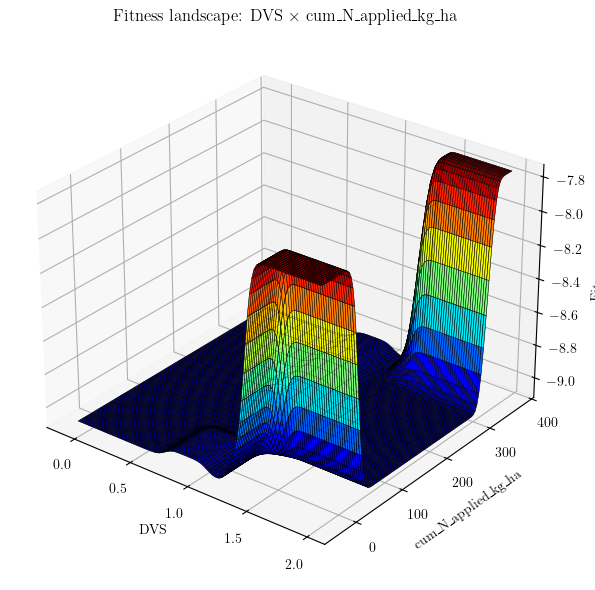

'\nPGFPLOTS usage (if you enabled CSV export):\n\x08egin{tikzpicture}\n\x08egin{axis}[view={28}{52}, xlabel={DVS}, ylabel={cum_N_applied_kg_ha}, zlabel={Fitness}]\n\\addplot3[surf] table[x=x,y=y,z=z, col sep=comma] {landscape_table.csv};\n\\end{axis}\n\\end{tikzpicture}\n'

In [12]:
# === Flexible fitness landscape (choose axes, z, ranges, and alternate CSV columns) ===
import os, contextlib
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib as mpl
from matplotlib.backends.backend_pgf import FigureCanvasPgf
mpl.backend_bases.register_backend('pgf', FigureCanvasPgf)

# --- CONFIG ------------------------------------------------------------------
CSV = r"C:\Users\Simon\PycharmProjects\Masterthesis7\data\wofost81\output\population_min.csv"

# The order your agent used for lower[i]/upper[i]/mask[i]
FEATURE_ORDER = [
    "DVS","LAI","RFTRA","WSO","Nsurp_sofar","last_dose_kg_ha","last_app_gap_days",
    "cum_N_applied_kg_ha","IRRAD_7","TMEAN_7","RAIN_7","Ndep_sum","SM_mean",
]
K = len(FEATURE_ORDER)

# Pick what to plot
X_FEAT = "DVS"
Y_FEAT = "cum_N_applied_kg_ha"

# Z surface: 'max' (max_a P_a(s)) or 'fixed_action'
Z_MODE = "max"           # "max" or "fixed_action"
Z_ACTION = 10            # only used if Z_MODE == "fixed_action" (dose index)

N_GRID = 110             # grid resolution
MIN_EXP = 1              # ignore very immature rules
SAVE_PNG = False
OUT = "landscape.png"

# (Optional) manually override axis ranges
AXIS_RANGE_OVERRIDE = {
    # "DVS": (0.0, 2.0),
    # "Nsurp_sofar": (-50, 150),
}

# (Optional) convert display units <-> model units (used at grid creation time)
# Example: if WSO in model is normalized 0..1 but you want kg/ha on the axis:
# AXIS_TO_MODEL["WSO"] = lambda raw: raw/15000.0
# AXIS_FROM_MODEL["WSO"] = lambda m: m*15000.0
AXIS_TO_MODEL  = {}
AXIS_FROM_MODEL = {}

# (Optional) tell the code to use *named* CSV columns for a feature’s intervals,
# instead of lower[i]/upper[i]/mask[i]. ONLY put entries you actually have.
# Example if your CSV also has "DVS_lo_raw","DVS_hi_raw","DVS_mask":
# INTERVAL_OVERRIDE = {"DVS": ("DVS_lo_raw","DVS_hi_raw","DVS_mask")}
INTERVAL_OVERRIDE = {}

# --- NEW: LaTeX export options ------------------------------------------------
SAVE_FOR_LATEX = True                       # master toggle
LATEX_BASENAME = os.path.splitext(OUT)[0]   # base name for outputs (no extension)
LATEX_EXPORT = {
    "pdf": True,    # vector PDF for \includegraphics
    "pgf": False,   # TikZ/PGF for \input (can be heavy for 3D)
    "csv": True,    # table for pgfplots \addplot3[surf] table
}
# Use LaTeX fonts/engine for consistent typography
LATEX_RC = {
    "text.usetex": True,
    "font.family": "serif",
    "axes.unicode_minus": False,
    "pgf.rcfonts": False,
    "pgf.texsystem": "pdflatex",
}

# --- LOAD --------------------------------------------------------------------
df = pd.read_csv(CSV)

def col_or_none(name):
    return name if name in df.columns else None

# Build default interval matrices from indexed columns
lower = np.stack([df[f"lower[{i}]"].to_numpy(float) for i in range(K)], axis=1)
upper = np.stack([df[f"upper[{i}]"].to_numpy(float) for i in range(K)], axis=1)
mask  = np.stack([df[f"mask[{i}]"].to_numpy(int)   for i in range(K)], axis=1).astype(bool)  # True = don't care

# If you have alternate columns for a particular feature, swap them in here
for feat, cols in INTERVAL_OVERRIDE.items():
    i = FEATURE_ORDER.index(feat)
    lo_col, hi_col, mask_col = cols
    assert lo_col in df.columns and hi_col in df.columns and mask_col in df.columns, \
        f"Missing override columns for {feat}: {cols}"
    lower[:, i] = df[lo_col].to_numpy(float)
    upper[:, i] = df[hi_col].to_numpy(float)
    mask[:,  i] = df[mask_col].to_numpy(int).astype(bool)

cares = ~mask

pred = df["pred"].to_numpy(float)
fit  = df["fit"].to_numpy(float)
num  = df["num"].to_numpy(float) if "num" in df.columns else np.ones(len(df))
eps  = df["eps"].to_numpy(float) if "eps" in df.columns else np.zeros(len(df))
exp  = df["exp"].to_numpy(float) if "exp" in df.columns else np.zeros(len(df))
act  = df["action"].to_numpy()

# --- HELPERS -----------------------------------------------------------------
def typical_values():
    tv = np.zeros(K, dtype=float)
    for i in range(K):
        idx = np.where(cares[:, i])[0]
        mids = 0.5*(lower[idx, i] + upper[idx, i]) if idx.size else 0.5*(lower[:, i] + upper[:, i])
        tv[i] = float(np.nanmedian(mids))
    return tv

def robust_axis_domain(i, qlo=0.02, qhi=0.98):
    # If user supplied a manual override, use it (in DISPLAY units)
    feat = FEATURE_ORDER[i]
    if feat in AXIS_RANGE_OVERRIDE:
        lo_disp, hi_disp = AXIS_RANGE_OVERRIDE[feat]
        # convert to model units for matching
        to_model = AXIS_TO_MODEL.get(feat, lambda v: v)
        return to_model(lo_disp), to_model(hi_disp)

    # Otherwise infer from intervals (model units)
    idx = np.where(cares[:, i])[0]
    lo_vals = lower[idx, i] if idx.size else lower[:, i]
    hi_vals = upper[idx, i] if idx.size else upper[:, i]
    lo_q = float(np.nanquantile(lo_vals, qlo))
    hi_q = float(np.nanquantile(hi_vals, qhi))
    if not np.isfinite(hi_q) or hi_q <= lo_q or hi_q > 1e6:
        hi_q = float(np.nanquantile(lo_vals, qhi))
    return lo_q, hi_q

def system_prediction_from_subset(idx_rows):
    w = fit[idx_rows] * num[idx_rows]
    w = w / (1.0 + np.maximum(eps[idx_rows], 0.0))
    a = act[idx_rows]; p = pred[idx_rows]
    Pa = {}
    for ua in np.unique(a):
        sel = (a == ua)
        wsum = float(np.sum(w[sel]))
        if wsum > 0:
            Pa[ua] = float(np.dot(w[sel], p[sel]) / wsum)
    return Pa

def build_landscape(x_feat, y_feat, n_grid=N_GRID, min_exp=MIN_EXP):
    tv = typical_values()
    xi = FEATURE_ORDER.index(x_feat)
    yi = FEATURE_ORDER.index(y_feat)

    # grid in MODEL units (because matching needs model units)
    x_lo_m, x_hi_m = robust_axis_domain(xi)
    y_lo_m, y_hi_m = robust_axis_domain(yi)
    X_model = np.linspace(x_lo_m, x_hi_m, n_grid)
    Y_model = np.linspace(y_lo_m, y_hi_m, n_grid)

    # also compute DISPLAY values for nice axis labels
    from_model_x = AXIS_FROM_MODEL.get(x_feat, lambda v: v)
    from_model_y = AXIS_FROM_MODEL.get(y_feat, lambda v: v)
    X_disp = from_model_x(X_model)
    Y_disp = from_model_y(Y_model)

    Z = np.full((n_grid, n_grid), np.nan, dtype=float)

    # Pre-filter per X to speed up
    for ix, xv in enumerate(X_model):
        s = tv.copy(); s[xi] = float(xv)
        s_row = s.reshape(1, K)
        ge_lo_x = lower <= s_row
        le_hi_x = s_row <= upper
        match_x = np.all(np.logical_or(~cares, (ge_lo_x & le_hi_x)), axis=1) & (exp >= min_exp)
        idx_x = np.where(match_x)[0]
        if idx_x.size == 0:
            continue

        # Precompute arrays for Y test on that subset
        lower_y = lower[idx_x, yi]; upper_y = upper[idx_x, yi]; cares_y = cares[idx_x, yi]
        a = act[idx_x]; p = pred[idx_x]
        w_base = fit[idx_x] * num[idx_x] / (1.0 + np.maximum(eps[idx_x], 0.0))

        for iy, yv in enumerate(Y_model):
            within_y = np.logical_or(~cares_y, ((lower_y <= yv) & (yv <= upper_y)))
            sub = np.where(within_y)[0]
            if sub.size == 0:
                continue
            ww = w_base[sub]; aa = a[sub]; pp = p[sub]

            if Z_MODE == "max":
                # system prediction per action -> take max
                Pa = {}
                for ua in np.unique(aa):
                    sel = (aa == ua)
                    wsum = float(np.sum(ww[sel]))
                    if wsum > 0:
                        Pa[ua] = float(np.dot(ww[sel], pp[sel]) / wsum)
                if Pa:
                    Z[iy, ix] = max(Pa.values())
            else:
                # show fixed action's predicted payoff
                sel = (aa == Z_ACTION)
                wsum = float(np.sum(ww[sel]))
                if wsum > 0:
                    Z[iy, ix] = float(np.dot(ww[sel], pp[sel]) / wsum)

    return X_disp, Y_disp, Z  # display-space axes for plotting

def inpaint_and_smooth(Z, iters=8):
    # light inpaint + smoothing for presentation
    Z = Z.copy()
    h, w = Z.shape
    # inpaint
    for _ in range(60):
        nan_mask = np.isnan(Z)
        if not nan_mask.any(): break
        Z_new = Z.copy(); changed=0
        for i in range(h):
            for j in range(w):
                if np.isnan(Z[i, j]):
                    vals = []
                    for di in (-1,0,1):
                        for dj in (-1,0,1):
                            if di==0 and dj==0: continue
                            ii, jj = i+di, j+dj
                            if 0<=ii<h and 0<=jj<w and not np.isnan(Z[ii, jj]):
                                vals.append(Z[ii, jj])
                    if vals:
                        Z_new[i, j] = float(np.mean(vals)); changed += 1
        Z = Z_new
        if changed == 0: break
    # smooth
    for _ in range(iters):
        Z_new = Z.copy()
        for i in range(h):
            for j in range(w):
                vals = []
                for di in (-1,0,1):
                    for dj in (-1,0,1):
                        ii, jj = i+di, j+dj
                        if 0<=ii<h and 0<=jj<w and not np.isnan(Z[ii, jj]):
                            vals.append(Z[ii, jj])
                if vals:
                    Z_new[i, j] = float(np.mean(vals))
        Z = Z_new
    return Z

def _latex_rc_context(enabled: bool):
    return plt.rc_context(LATEX_RC) if enabled else contextlib.nullcontext()

def plot_surface(X, Y, Z, xlab, ylab, title=None, out_png=None, latex_fonts=False):
    XX, YY = np.meshgrid(X, Y)
    Z = inpaint_and_smooth(Z, iters=10)

    vmin = float(np.nanpercentile(Z, 2))
    vmax = float(np.nanpercentile(Z, 98))
    norm = colors.Normalize(vmin=vmin, vmax=vmax)

    with _latex_rc_context(latex_fonts):
        fig = plt.figure(figsize=(10,6), facecolor="white")
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(XX, YY, Z, cmap="jet", norm=norm,
                        edgecolor="k", linewidth=0.35, rstride=1, cstride=1,
                        antialiased=True, alpha=1.0, shade=True)
        ax.plot_wireframe(XX, YY, Z, rstride=6, cstride=6, color="k", linewidth=0.30, alpha=0.5)
        ax.set_xlabel(xlab); ax.set_ylabel(ylab); ax.set_zlabel("Fitness")
        if title: ax.set_title(title)
        ax.view_init(elev=28, azim=-52)
        plt.tight_layout()
        if SAVE_PNG and out_png:
            fig.savefig(out_png, dpi=300, bbox_inches="tight")
        plt.show()
    return fig, ax

# --- NEW: Save helpers for LaTeX ---------------------------------------------
def save_for_latex(fig, X, Y, Z, basename=LATEX_BASENAME):
    base = basename if os.path.isabs(basename) else os.path.join(".", basename)

    # 1) PDF (vector) — recommended for \includegraphics
    if LATEX_EXPORT.get("pdf", False):
        with plt.rc_context(LATEX_RC):
            fig.savefig(base + ".pdf", bbox_inches="tight")

    # 2) PGF (TikZ/PGF) — use \input{...} (can be large/slow for 3D)
    if LATEX_EXPORT.get("pgf", False):
        with plt.rc_context(LATEX_RC):
            fig.savefig(base + ".pgf", bbox_inches="tight")

    # 3) CSV table — for pgfplots \addplot3[surf] table
    if LATEX_EXPORT.get("csv", False):
        XX, YY = np.meshgrid(X, Y)
        df_out = pd.DataFrame({
            "x": XX.ravel(order="C"),
            "y": YY.ravel(order="C"),
            "z": Z.ravel(order="C"),
        })
        df_out.to_csv(base + "_table.csv", index=False)

# --- BUILD & PLOT ------------------------------------------------------------
X, Y, Z = build_landscape(X_FEAT, Y_FEAT)
fig, ax = plot_surface(
    X, Y, Z,
    xlab=X_FEAT, ylab=Y_FEAT,
    title=f"Fitness landscape: {X_FEAT} × {Y_FEAT}",
    out_png=OUT,
    latex_fonts=SAVE_FOR_LATEX  # render with LaTeX fonts if exporting
)

if SAVE_FOR_LATEX:
    # saves: <basename>.pdf / .pgf / _table.csv (per LATEX_EXPORT flags)
    save_for_latex(fig, X, Y, Z, basename=LATEX_BASENAME)

"""
PGFPLOTS usage (if you enabled CSV export):
\begin{tikzpicture}
\begin{axis}[view={28}{52}, xlabel={""" + X_FEAT + r"""}, ylabel={""" + Y_FEAT + r"""}, zlabel={Fitness}]
\addplot3[surf] table[x=x,y=y,z=z, col sep=comma] {""" + LATEX_BASENAME + r"""_table.csv};
\end{axis}
\end{tikzpicture}
"""
